**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: RAG

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/rag_guide.ipynb](guides/rag_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `rag_guide` notebook to create your own RAG system.

<br>

***

#### Imports

In [2]:
from typing import Literal, Any
from copy import deepcopy

from typing_extensions import TypedDict
import matplotlib.pyplot as plt
import numpy as np
from decouple import config
from pydantic import BaseModel, Field
from IPython.display import Image, display
from tqdm import tqdm

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters.markdown import MarkdownHeaderTextSplitter
from langchain.prompts import PromptTemplate
from langchain_ibm import WatsonxEmbeddings
from langchain_ibm import WatsonxLLM
from langgraph.graph import START, StateGraph
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

import litellm
from litellm import completion
import instructor
from instructor import Mode

import json

## Set up LLM access

#### Retrieve secrets

In [3]:
json_file_path = "/Users/henrikjacobsen/Desktop/CBS/Semester 2/Artifical Intelligence and Machine Learning/apikey.json"

with open(json_file_path, "r") as file:
    data = json.load(file)

WX_API_KEY = data.get("apikey")

if WX_API_KEY:
    print("API Key loaded successfully!")
else:
    print("Error: API Key not found in JSON file.")

WX_PROJECT_ID = "a8a394fd-a1b7-4dbe-b947-3a0684bbd947"
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

API Key loaded successfully!


#### Authenticate and initialize LLM

In [4]:
llm = WatsonxLLM(

        model_id= "ibm/granite-3-8b-instruct",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Use LLM

In [5]:
llm_result = llm.generate(["Hi how are you?"])

print(type(llm_result))
print(llm_result)

<class 'langchain_core.outputs.llm_result.LLMResult'>
generations=[[Generation(text="\nI'm an artificial intelligence and don't have feelings, but I'm here to help you. How can I assist you today?", generation_info={'finish_reason': 'eos_token'})]] llm_output={'token_usage': {'generated_token_count': 31, 'input_token_count': 5}, 'model_id': 'ibm/granite-3-8b-instruct', 'deployment_id': None} run=[RunInfo(run_id=UUID('e65056be-8793-4b23-9450-3d2d9713136d'))] type='LLMResult'


## Document processing

#### Load documents

In [6]:
document = TextLoader("data/madeup_company.md").load()[0]
document.metadata

{'source': 'data/madeup_company.md'}

#### Split documents

In [7]:
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2"), ("###", "Header 3"), ("####", "Header 4")]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
chunks = text_splitter.split_text(document.page_content)

In [8]:
chunks

[Document(metadata={'Header 1': 'About MadeUpCompany'}, page_content='MadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
 Document(metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Our Values'}, page_content="At MadeUpCompany, we believe in:  \n- Innovation – Continuously developing and refining solutions that meet the evolving needs of 

#### Preprocess chunks

In [9]:
def update_documents_with_headers(chunks):
    """
    Creates a new list of Document objects with page_content prepended with headers
    in [Header1/Header2/Header3]: format
    
    Returns new objects rather than modifying the original chunks
    """
    updated_chunks = []
    
    for doc in chunks:
        # Create a deep copy of the document to avoid modifying the original
        new_doc = deepcopy(doc)
        
        # Get all headers that exist in metadata
        headers = []
        for i in range(1, 4):
            key = f'Header {i}'
            if key in new_doc.metadata:
                headers.append(new_doc.metadata[key])
        
        # Create the header prefix and update page_content
        if headers:
            prefix = f"[{'/'.join(headers)}]: "
            new_doc.page_content = prefix + "\n" + new_doc.page_content
        
        updated_chunks.append(new_doc)
    
    return updated_chunks


docs = update_documents_with_headers(chunks)

In [10]:
for doc in docs:
    print(doc.page_content, end="\n\n")

[About MadeUpCompany]: 
MadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  
With a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.

[About MadeUpCompany/Our Values]: 
At MadeUpCompany, we believe in:  
- Innovation – Continuously developing and refining solutions that meet the evolving needs of businesses.
- Security & Privacy – Implementing world-class security protocols to protect our customers' data.


## Embedding

### Initialize the embedding model

In [11]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

#### Create vector index

In [12]:
local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=docs,
    
)

#### Semantic search

In [13]:
# Use the vectorstore as a retriever
retriever = local_vector_db.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 3,
    }
)

In [14]:

# Retrieve the most similar text
retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

for document in retrieved_documents:
    print(f"{'#' * 80}\nID: {document.id}")
    first_n_of_content = document.page_content[:500].replace('\n\n', ' ')
    print(f"Content: {first_n_of_content}\n")


################################################################################
ID: 6cae7d46-6e66-4b25-8e39-d8c0b80c4cbd
Content: [About MadeUpCompany/Refund and Cancellation Policy]: 
We stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  
If you're not satisfied, you can request a full refund within the first 30 days.
After 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.
Enterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.
Upcoming Features

################################################################################
ID: c4ec37fa-6bd8-4d28-a8d1-62ee4c027f2c
Content: [About MadeUpCompany/Refund and Cancellation Policy]: 
We stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  
If you're not satisfied, you can request a full refund within the first 30 days.
After 30 days, you 

## Prompt template

In [15]:
template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
{question}

Context: 
{context} 

Answer:
"""

prompt = PromptTemplate.from_template(template)

In [16]:
prompt.invoke(
    input={
        "question": "What is CloudMate?",
        "context": retrieved_documents[0].page_content,
    }
)

StringPromptValue(text="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n\nQuestion:\nWhat is CloudMate?\n\nContext: \n[About MadeUpCompany/Refund and Cancellation Policy]: \nWe stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  \nIf you're not satisfied, you can request a full refund within the first 30 days.\nAfter 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.\nEnterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.\nUpcoming Features \n\nAnswer:\n")

## Combining the rag pipeline

In [17]:
question = "What is CloudMate?"

retrieved_docs = local_vector_db.similarity_search(question)
docs_content = "\n\n".join(f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(retrieved_docs))
formated_prompt = prompt.invoke({"question": question, "context": docs_content})

In [18]:
print(formated_prompt.to_string()[:1000])

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
What is CloudMate?

Context: 
Document 1:
[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: 
CloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:
- ✅ Seamless data migration with automated backups
- ✅ Military-grade encryption and multi-factor authentication
- ✅ Role-based access control for enterprise security
- ✅ AI-powered file organization and search capabilities

Document 2:
[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: 
CloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:
- ✅ Seamless data migration with automated backups
- ✅ Military-grade encryp

In [19]:
answer = llm.invoke(formated_prompt)

In [20]:
print(answer)

CloudMate is a flagship cloud storage solution by MadeUpCompany, offering seamless data migration, military-grade encryption, role-based access control, and AI-powered file organization across various business-sized plans.


## Running RAG pipeline

In [21]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = local_vector_db.similarity_search(state["question"], k=3) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph

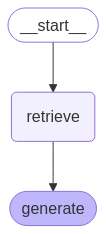

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
response = graph.invoke({"question": "What is CloudMate?"})

response

{'question': 'What is CloudMate?',
 'context': [Document(id='d79bd8e1-2040-4bb4-a431-8fc4e6e9fd47', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Products and Services', 'Header 3': 'CloudMate – Secure and Scalable Cloud Storage'}, page_content='[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: \nCloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:\n- ✅ Seamless data migration with automated backups\n- ✅ Military-grade encryption and multi-factor authentication\n- ✅ Role-based access control for enterprise security\n- ✅ AI-powered file organization and search capabilities'),
  Document(id='b36ca496-daf5-422f-ae9a-2bf4d99fef45', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Products and Services', 'Header 3': 'CloudMate – Secure and Scalable Cloud Storage'}, page_content='[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: \nCloudMa

## Evaluation

In [24]:
sample_queries = [
    "When was MadeUpCompany founded and where is it headquartered?",
    "What security features does CloudMate offer for enterprise customers?",
    "How much does the Professional plan for CloudMate cost and what storage capacity does it include?",
    "What analytics capabilities does DataWiz provide for business intelligence?",
    "What compliance standards does MadeUpCompany adhere to?",
    "What channels are available for technical support at MadeUpCompany?",
    "What is MadeUpCompany's refund policy for the first 30 days?",
    "What upcoming collaboration features is MadeUpCompany planning for CloudMate?",
    "Where are MadeUpCompany's satellite offices located?",
    "What four core values does MadeUpCompany believe in?",
    "What professional backgrounds do MadeUpCompany's experts come from?",
    "What does the Starter plan for DataWiz include and how much does it cost?",
    "How quickly does MadeUpCompany promise to resolve technical issues?",
    "What account management features are available through MadeUpCompany's online portal?",
    "How many users does MadeUpCompany have and what publications have featured them?",
    "What types of custom AI solutions does MadeUpCompany develop?",
    "What encryption standard does MadeUpCompany use and where is it applied?",
    "What are the specifications of the Basic plan for CloudMate?",
    "What is the guaranteed response time for email support at MadeUpCompany?",
    "What capabilities does DataWiz offer for fraud prevention?",
    "How does MadeUpCompany's cancellation policy work after the 30-day period?",
    "What machine learning capabilities will DataWiz introduce in upcoming features?",
    "What pricing plan options are available for MadeUpCompany's Enterprise customers?",
    "What does MadeUpCompany's sustainability value focus on?",
    "How does MadeUpCompany describe its mission?"
]

expected_responses = [
    "MadeUpCompany was founded in 2010 and is headquartered in San Francisco, California.",
    "CloudMate offers military-grade encryption, multi-factor authentication, and role-based access control for enterprise security.",
    "The Professional plan for CloudMate costs $29.99/month and includes 1TB of storage, enhanced security, and priority support.",
    "DataWiz provides predictive analytics for demand forecasting and customer behavior modeling, real-time dashboards with customizable reporting, API integrations with popular business intelligence tools, and automated anomaly detection.",
    "MadeUpCompany adheres to GDPR, HIPAA, and SOC 2 compliance standards for global security and data protection compliance.",
    "MadeUpCompany offers toll-free phone support, live chat assistance, email support, comprehensive FAQ and user guides on their website, and a community forum for peer-to-peer discussions.",
    "MadeUpCompany offers a 30-day money-back guarantee on all plans, allowing customers to request a full refund if they're not satisfied within the first 30 days.",
    "MadeUpCompany is planning to introduce enhanced real-time document editing and team workspaces for seamless collaboration in CloudMate.",
    "MadeUpCompany has satellite offices in New York, London, and Tokyo.",
    "MadeUpCompany believes in innovation, security & privacy, a customer-centric approach, and sustainability.",
    "MadeUpCompany's experts come from various industries including AI research, cybersecurity, and enterprise software development.",
    "The Starter plan for DataWiz costs $49/month and includes basic analytics and limited AI insights.",
    "MadeUpCompany resolves most technical issues within 24 hours, ensuring minimal downtime for businesses.",
    "Through MadeUpCompany's online portal, customers can upgrade or downgrade plans, access billing history and download invoices, manage multiple users and set role-based permissions, and track storage and analytics usage in real time.",
    "MadeUpCompany has over 1 million satisfied users worldwide and has been featured in TechCrunch, Forbes, and Wired as a top innovator.",
    "MadeUpCompany provides tailored machine learning models including NLP-based chatbots and AI-driven recommendation engines to optimize business workflows, automate repetitive tasks, and enhance decision-making.",
    "MadeUpCompany uses AES-256 encryption to protect data both in transit and at rest.",
    "The Basic plan for CloudMate costs $9.99/month and includes 100GB storage and essential security features.",
    "MadeUpCompany guarantees an email support response within 6 hours.",
    "DataWiz provides automated anomaly detection for fraud prevention and operational efficiency.",
    "After 30 days, customers may cancel their subscription at any time, and MadeUpCompany will issue a prorated refund based on the remaining subscription period.",
    "DataWiz will introduce automated trend forecasting powered by deep learning.",
    "MadeUpCompany offers custom pricing for Enterprise plans with unlimited storage, advanced compliance tools, and a dedicated account manager for CloudMate, and full AI customization with dedicated data scientists for DataWiz.",
    "MadeUpCompany's sustainability value focuses on ensuring their infrastructure is energy-efficient and environmentally responsible.",
    "MadeUpCompany's mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation."
]

In [25]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        api_key=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

In [26]:
class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }

In [27]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Exact fact stated' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


  4%|▍         | 1/25 [00:08<03:29,  8.73s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches CloudMate features' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  8%|▊         | 2/25 [00:17<03:20,  8.72s/it]

[evaluation_hallucination] LLM response: reasoning='Answer rephrased from documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Missing extra features' score=0.5


 12%|█▏        | 3/25 [00:25<03:07,  8.53s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 16%|█▌        | 4/25 [00:34<02:58,  8.52s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 5/25 [00:42<02:50,  8.51s/it]

[evaluation_hallucination] LLM response: reasoning='Some details not directly asked' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 24%|██▍       | 6/25 [00:53<02:56,  9.29s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 28%|██▊       | 7/25 [01:02<02:46,  9.25s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 32%|███▏      | 8/25 [01:14<02:49,  9.99s/it]

[evaluation_hallucination] LLM response: reasoning="Added 'improve user experience' detail" score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Same content, different wording' score=1


 36%|███▌      | 9/25 [01:26<02:49, 10.61s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Identical content' score=1


 40%|████      | 10/25 [01:35<02:31, 10.08s/it]

[evaluation_hallucination] LLM response: reasoning='Answer directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 44%|████▍     | 11/25 [01:44<02:16,  9.74s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 12/25 [01:53<02:03,  9.49s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unsupported features' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Partial detail' score=0.5


 52%|█████▏    | 13/25 [02:00<01:48,  9.01s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 56%|█████▌    | 14/25 [02:09<01:36,  8.77s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 60%|██████    | 15/25 [02:19<01:32,  9.24s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is accurate' score=1


 64%|██████▍   | 16/25 [02:28<01:22,  9.17s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Matching fact found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 68%|██████▊   | 17/25 [02:38<01:14,  9.31s/it]

[evaluation_hallucination] LLM response: reasoning='Global application inferred' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 72%|███████▏  | 18/25 [02:47<01:05,  9.37s/it]

[evaluation_hallucination] LLM response: reasoning='Includes features not in Basic plan' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Email support guarantee found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is correct' score=1


 76%|███████▌  | 19/25 [02:58<00:58,  9.75s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 80%|████████  | 20/25 [03:11<00:53, 10.65s/it]

[evaluation_hallucination] LLM response: reasoning='Adds details not in context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 84%|████████▍ | 21/25 [03:20<00:40, 10.15s/it]

[evaluation_hallucination] LLM response: reasoning='Minor addition' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 3' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 88%|████████▊ | 22/25 [03:28<00:29,  9.72s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unrelated CloudMate features' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial info present' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct info' score=0.5


 92%|█████████▏| 23/25 [03:37<00:19,  9.53s/it]

[evaluation_hallucination] LLM response: reasoning='Answer adds unstated specifics' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is essentially identical' score=1


 96%|█████████▌| 24/25 [03:47<00:09,  9.44s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


100%|██████████| 25/25 [04:02<00:00,  9.70s/it]

[evaluation_hallucination] LLM response: reasoning='Added unsuppoted details' score=1


{'retrieval_quality': 0.98, 'answer_correctness': 0.94, 'hallucination': 0.3}

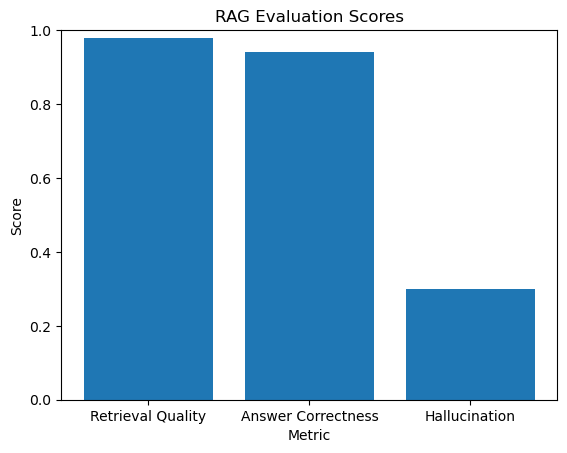

In [28]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

In [29]:
results["individual_results"][:5]

[{'query': 'When was MadeUpCompany founded and where is it headquartered?',
  'retrieved_context': [Document(id='ed9530ce-cbf7-4384-84d1-90d1770027b4', metadata={'Header 1': 'About MadeUpCompany'}, page_content='[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
   Document(id='97024184-582c-4209-8414-a2746a1bf502', meta

## Reflection on Results


The evaluation results for the Retrieval-Augmented Generation (RAG) system indicate a strong performance overall.

- Retrieval Quality: Achieved a high average score (0.98), indicating excellent retrieval accuracy from the vector database.
- Answer Correctness: With an average score of 0.94, generated answers generally matched expected responses accurately, with occasional over-detailing.
- Hallucination Detection: Scored relatively low (0.3), suggesting minimal hallucination occurrences. However, there's room for improvement to reduce minor irrelevant details.

**Important Hyperparameters**
Several hyperparameters proved particularly important for the RAG system:

- `TEMPERATURE`:
  - Crucial for controlling randomness. A lower value (close to 0) produced more deterministic and accurate responses, significantly reducing hallucinations.

- `MAX_NEW_TOKENS`:
  - Vital for ensuring comprehensive answers without truncation. Setting this parameter to 1000 ensured sufficient detail without compromising clarity.

- `REPETITION_PENALTY`:
  - Important for improving readability and reducing repetitive content. The value of 1.2 provided a good balance between coherence and variability.

- `WatsonxEmbeddings:
  - Using a multilingual embedding model ("ibm/granite-embedding-278m-multilingual") significantly improved retrieval accuracy, particularly beneficial when handling diverse content.

- Vector Search Parameter (`k`):
  - Choosing the right number of retrieved documents (`k=3`) was critical, balancing context relevance with computational efficiency and avoiding information overload in the generated answers.

**Recommendations for Further Improvement**
- Experimenting further with the temperature could potentially reduce hallucination further.
- Adjusting the `k` value dynamically based on question complexity might optimize retrieval precision and response accuracy.
